In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import sys
import scipy.optimize as op
import scipy.stats as stt
seaborn.set(font_scale=1.75,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Simulate noisy responses that are sinusoidal
all_resps_g1 = np.array([np.random.randint(0,3)*np.sin(np.linspace(0,2*np.pi,num=9) + np.random.normal()) for _ in range(10)])

In [5]:
def fit_sin2(x,*params):
    """ Fit a sine wave"""
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc

In [28]:
# if you want to simulate aperiodic activity
x_ = np.random.permutation(np.linspace(0,2*np.pi,num=9))

# else
x_ = np.linspace(0,2*np.pi,num=9)

muNCycles = 3


resps_state_g1_ = np.array([np.sin(np.random.random()*muNCycles*2*x_ + np.random.random()*2*np.pi) for _ in range(30)])
resps_state_g2_ = np.array([np.sin(np.random.random()*muNCycles*2*x_ + np.random.random()*2*np.pi) for _ in range(30)])

In [29]:
resps_state_g1 = np.mean([np.random.poisson(np.exp(resps_state_g1_+2)).astype('float') for _ in range(15)],axis=0)
resps_state_g2 = np.mean([np.random.poisson(np.exp(resps_state_g2_+2)).astype('float') for _ in range(15)],axis=0)

In [30]:
np.min(resps_state_g1)

2.0

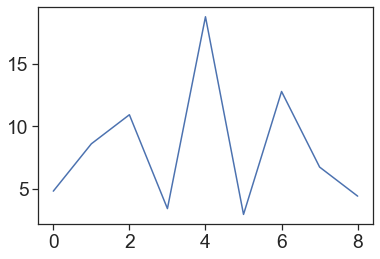

In [31]:
# Plot activity of an example neuron in each state
plt.plot(resps_state_g1[0])

# Do the actual fitting

In [32]:
res_t1 = []
res_t2 = []
all_cc = []
all_shuffle_cc = []
t_ = np.linspace(0,2*np.pi,9)
NSHUFF = 100
params_ranges = [slice(0,4,.5),slice(0,2*np.pi,np.pi/9)]
#params_ranges = [slice(0,4,.5),slice(0,np.pi,np.pi/9),slice(0,1,.25),slice(0,1,.25)]


n_neurons = resps_state_g1.shape[0]



for i in range(n_neurons):
    sys.stdout.write('\r running cell:{}'.format(i))
    sys.stdout.flush()
    
    y1 = resps_state_g1[i] #np.random.permutation(resps_state_g1[i])
    y2 = resps_state_g2[i] #np.random.permutation(resps_state_g2[i])
    spks = y1
    y = spks
    res1 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc1 = np.corrcoef(spks,np.cos(res1[0]*t_ + res1[1]))[0,1]
    
    cc1_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res1_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc1_shuff.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])
        



    
    

    spks = y2
    y = spks
   
    res2 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc2 = np.corrcoef(y,np.cos(res2[0]*t_ + res2[1]))[0,1]
    
    cc2_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res2_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc2_shuff.append(np.corrcoef(spks_shuff,np.cos(res2_shuff[0]*t_ + res2_shuff[1]))[0,1])

    all_cc.append([cc1,cc2])
    all_shuffle_cc.append([cc1_shuff,cc2_shuff])
    
    res_t1.append(res1)
    res_t2.append(res2)
all_cc = np.array(all_cc)
res_t1 = np.array(res_t1)
res_t2 = np.array(res_t2)

 running cell:0

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


NameError: name 'y' is not defined

# Process results to get p-values etc

In [ ]:
p_vals = []
for cell_ix,cell in enumerate(all_cc):
    tmp = []
    for task_nr in range(2):
        p1 = stt.percentileofscore(all_shuffle_cc[cell_ix][task_nr],cell[task_nr])
        tmp.append(p1)
    p_vals.append(tmp)

[3.         1.74532925]
[1.         3.83972435]


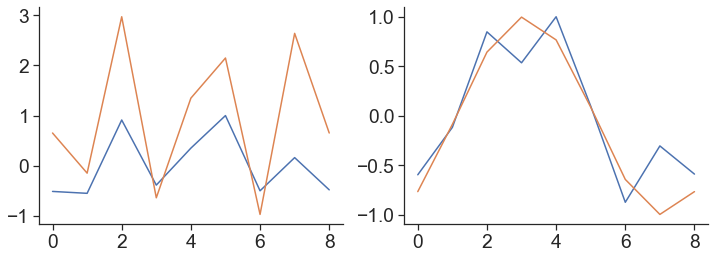

In [308]:
plt.figure(figsize=(12,4))
ix = 0
plt.subplot(1,2,1)
x = res_t1[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g1[ix])# - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)


pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(y)
plt.plot(pred*2+1)


plt.subplot(1,2,2)
x = res_t2[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g2[ix])# - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)
pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(y)
plt.plot(pred)

seaborn.despine()

In [309]:
np.mean((np.array(p_vals)>95))

0.06666666666666667

In [311]:
np.array([[4,4],[-3,3]])

array([[ 4,  4],
       [-3,  3]])